<a href="https://colab.research.google.com/github/SDS-AAU/dsba-cbs/blob/master/M3/workshop/SimpleRNN_stocks_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Time series prediction with LSTMs
This notebook is adopted from [Machine Learning Mastery](https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/)
Please visit the tutorial there for more details and to see variations of that using sliding windows and timesteps.




In [1]:
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
sns.set()

In [16]:
!pip install pandas-datareader

In [17]:
from pandas_datareader import data as pdr

In [37]:
import yfinance as yf
yf.pdr_override() # <== that's all it takes :-)

# download dataframe
data = pdr.get_data_yahoo("^OMXH25", start="2017-12-01", end="2020-12-01")

[*********************100%***********************]  1 of 1 completed


In [38]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 748 entries, 2017-12-01 to 2020-11-30
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       748 non-null    float64
 1   High       748 non-null    float64
 2   Low        748 non-null    float64
 3   Close      748 non-null    float64
 4   Adj Close  748 non-null    float64
 5   Volume     748 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 40.9 KB


In [78]:
data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-12-01,3914.330078,3915.100098,3872.439941,3874.820068,3874.820068,0
2017-12-04,3879.229980,3911.550049,3879.229980,3892.010010,3892.010010,0
2017-12-05,3889.620117,3913.209961,3877.510010,3887.729980,3887.729980,0
2017-12-06,3889.620117,3913.209961,3877.510010,3887.729980,3887.729980,0
2017-12-07,3884.810059,3895.649902,3863.040039,3864.179932,3864.179932,0
...,...,...,...,...,...,...
2020-11-24,4525.390137,4562.390137,4524.549805,4560.370117,4560.370117,0
2020-11-25,4574.439941,4594.890137,4558.290039,4575.080078,4575.080078,0
2020-11-26,4584.689941,4589.129883,4554.410156,4567.640137,4567.640137,31518700


In [87]:
data_diff = data.diff()

In [88]:
import numpy
import math

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [89]:
# fix random seed for reproducibility
numpy.random.seed(7)

In [90]:
# normalizing
scaler = MinMaxScaler(feature_range=(-1, 1))
data_diff['Adj_Close_scaled'] = scaler.fit_transform(data_diff['Adj Close'].values.reshape(-1, 1))

In [91]:
# create targets by shifting
data_diff['Adj_Close_scaled+1'] = data_diff.Adj_Close_scaled.shift(-1, fill_value=data_diff.Adj_Close_scaled.iloc[-1])

In [92]:
data_diff

,Open,High,Low,Close,Adj Close,Volume,Adj_Close_scaled,Adj_Close_scaled+1
Date,,,,,,,,
2017-12-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.339561
2017-12-04,-35.100098,-3.550049,6.790039,17.189941,17.189941,0.0,0.339561,0.262271
2017-12-05,10.390137,1.659912,-1.719971,-4.280029,-4.280029,0.0,0.262271,0.277678
2017-12-06,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.277678,0.192900
2017-12-07,-4.810059,-17.560059,-14.469971,-23.550049,-23.550049,0.0,0.192900,0.366812
...,...,...,...,...,...,...,...,...
2020-11-24,18.990234,36.439941,24.779785,53.560059,53.560059,0.0,0.470490,0.330633
2020-11-25,49.049805,32.500000,33.740234,14.709961,14.709961,0.0,0.330633,0.250895
2020-11-26,10.250000,-5.760254,-3.879883,-7.439941,-7.439941,31518700.0,0.250895,0.480964


In [93]:
# get the data as matrix
data_p = data_diff.iloc[1:,6:].values.astype('float32')

In [94]:
data_p

array([[0.3395605 , 0.26227063],
       [0.26227063, 0.27767834],
       [0.27767834, 0.19290037],
       ...,
       [0.25089526, 0.48096403],
       [0.48096403, 0.06366499],
       [0.06366499, 0.06366499]], dtype=float32)

In [95]:
# split into train and test sets
train_size = int(len(data_p) * 0.67)
test_size = len(data_p) - train_size
train, test = data_p[0:train_size,:], data_p[train_size:len(data_p),:]
print(len(train), len(test))

500 247


In [96]:
X_train = train[:,0]
y_train = train[:,1]

X_test = test[:,0]
y_test = test[:,1]

In [97]:
X_train.shape[0]

500

In [98]:
# reshape input to be [samples, time steps, features]
X_train = numpy.reshape(X_train, (X_train.shape[0], 1, 1))
X_test = numpy.reshape(X_test, (X_test.shape[0], 1, 1))

In [99]:
# build the network

model = Sequential()
model.add(LSTM(4, input_shape=(1, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [100]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 4)                 96        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 5         
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________


In [101]:
model.fit(X_train, y_train, epochs=50, batch_size=20, verbose=2)

Epoch 1/50
25/25 - 0s - loss: 0.0670
Epoch 2/50
25/25 - 0s - loss: 0.0463
Epoch 3/50
25/25 - 0s - loss: 0.0325
Epoch 4/50
25/25 - 0s - loss: 0.0241
Epoch 5/50
25/25 - 0s - loss: 0.0206
Epoch 6/50
25/25 - 0s - loss: 0.0192
Epoch 7/50
25/25 - 0s - loss: 0.0189
Epoch 8/50
25/25 - 0s - loss: 0.0187
Epoch 9/50
25/25 - 0s - loss: 0.0187
Epoch 10/50
25/25 - 0s - loss: 0.0186
Epoch 11/50
25/25 - 0s - loss: 0.0186
Epoch 12/50
25/25 - 0s - loss: 0.0185
Epoch 13/50
25/25 - 0s - loss: 0.0185
Epoch 14/50
25/25 - 0s - loss: 0.0184
Epoch 15/50
25/25 - 0s - loss: 0.0184
Epoch 16/50
25/25 - 0s - loss: 0.0184
Epoch 17/50
25/25 - 0s - loss: 0.0183
Epoch 18/50
25/25 - 0s - loss: 0.0183
Epoch 19/50
25/25 - 0s - loss: 0.0182
Epoch 20/50
25/25 - 0s - loss: 0.0182
Epoch 21/50
25/25 - 0s - loss: 0.0182
Epoch 22/50
25/25 - 0s - loss: 0.0181
Epoch 23/50
25/25 - 0s - loss: 0.0181
Epoch 24/50
25/25 - 0s - loss: 0.0181
Epoch 25/50
25/25 - 0s - loss: 0.0181
Epoch 26/50
25/25 - 0s - loss: 0.0180
Epoch 27/50
25/25 - 0

In [102]:
# make predictions
trainPredict = model.predict(X_train)
testPredict = model.predict(X_test)

In [103]:
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
y_train = scaler.inverse_transform([y_train])

testPredict = scaler.inverse_transform(testPredict)
y_test = scaler.inverse_transform([y_test])

In [104]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 36.97 RMSE
Test Score: 65.70 RMSE


In [105]:
data_diff['Adj_close_pred'] = data_diff['Adj Close']

In [106]:
testPredict.shape

(247, 1)

In [107]:
data_diff['Adj_close_pred'].iloc[-247:] = testPredict.flatten()

In [108]:
data_diff['Adj_close_pred']

Date
2017-12-01          NaN
2017-12-04    17.189941
2017-12-05    -4.280029
2017-12-06     0.000000
2017-12-07   -23.550049
                ...    
2020-11-24     3.918793
2020-11-25     1.779808
2020-11-26     0.249361
2020-11-27     4.050548
2020-11-30    -4.188685
Name: Adj_close_pred, Length: 748, dtype: float64

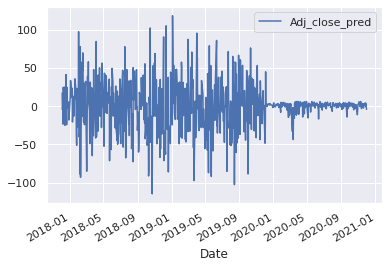

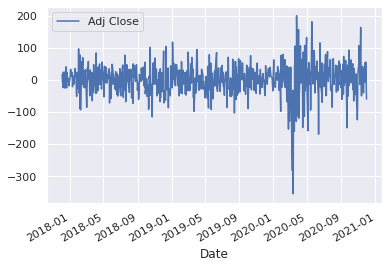

In [109]:
data_diff.loc[:,['Adj_close_pred']].plot()
data_diff.loc[:,['Adj Close']].plot()